## Init

In [1]:
import os
import operator
import csv
import datetime as dt
import numpy as np
import pandas as pd
import math
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [2]:
run_prefix = 'run_01_02'

In [3]:
dir_root = os.path.join('..')
dir_data = os.path.join(dir_root, 'data_processing')
dir_tickers = os.path.join(dir_data, 'tickers')
dir_run = os.path.join(dir_root, 'data_runs', run_prefix)
dir_result_dtm = os.path.join(dir_run, 'results', 'lda-seq')
dir_result_interpretation = os.path.join(dir_run, 'interpretation')

## Read topics amount and time slices amount

In [4]:
number_of_topics = None
time_slices = None
with open(os.path.join(dir_result_dtm, 'info.dat'), 'r') as f_r:
    for text_line in f_r:
        data = text_line.strip().split(' ')
        if data[0] == 'NUM_TOPICS':
            number_of_topics = int(data[1])
        if data[0] == 'SEQ_LENGTH':
            time_slices = int(data[1])
            
print(number_of_topics) 
print(time_slices)

10
13


## Read terms

In [5]:
terms_list = []
with open(os.path.join(dir_run, "%s-terms.dat" % run_prefix), 'r') as f_r:
    for text_line in f_r:
        term = text_line.strip()
        if len(term):
            terms_list.append(term)

## Get top terms

In [6]:
take_top = 10
flag_is_exp = True

In [7]:
dir_result_top_terms = os.path.join(dir_result_interpretation, 'top_terms')
if not os.path.exists(dir_result_top_terms):
    os.makedirs(dir_result_top_terms)

In [8]:
def get_sorted_terms(topic_id):
    #create time slice data
    all_time_slices_data_unsorted = {}
    for time_slice in range(time_slices):
        all_time_slices_data_unsorted[time_slice] = list()

    #open terms distribution file
    with open(os.path.join(dir_result_dtm, "topic-%s-var-e-log-prob.dat" % topic_id), 'r') as f_r:
        distributions = f_r.readlines()
        dist_x = 0
        #for each term read one line
        for term in terms_list:
            # for each time slice
            for time_slice in range(time_slices):
                float_text = distributions[dist_x].strip()
                if len(float_text):
                    if flag_is_exp:
                        term_probability = math.exp(float(float_text))
                    else:
                        term_probability = float(float_text)
                    all_time_slices_data_unsorted[time_slice].append((term, term_probability))
                dist_x += 1

    # sort list
    all_time_slices_data_sorted = []
    for time_slice in range(time_slices):
        all_time_slices_data_sorted.append(sorted(all_time_slices_data_unsorted[time_slice],
                                                  key=operator.itemgetter(1),
                                                  reverse=True))
    
    return all_time_slices_data_sorted

In [9]:
def store_sorted_terms(topic_id, all_time_slices_data_sorted):
    #save as csv without probabilities for better visualisation and limited to take top
    file_csv_sorted_terms_without_probabilities = os.path.join(
        dir_result_top_terms, "%s-top-n-terms.csv" % topic_id)
    with open(file_csv_sorted_terms_without_probabilities, 'w') as f_w:
        for i in range(take_top):
            terms_at_position_list = []
            for time_slice in range(time_slices):
                terms_at_position_list.append(all_time_slices_data_sorted[time_slice][i][0])
            f_w.write("%s\n" % (','.join(terms_at_position_list)))

    #save as csv with probabilities
    file_csv_sorted_terms_with_probabilities = os.path.join(
        dir_result_top_terms, "%s-terms_sorted.csv" % topic_id)
    with open(file_csv_sorted_terms_with_probabilities, 'w') as f_w:
        for i in range(len(terms_list)):
            terms_at_position_list = list()
            for time_slice in range(time_slices):
                terms_at_position_list.append(all_time_slices_data_sorted[time_slice][i][0])
                terms_at_position_list.append(all_time_slices_data_sorted[time_slice][i][1])
            f_w.write("%s\n" % (','.join(map(str, terms_at_position_list))))

In [10]:
for i in range(number_of_topics):
    print("Run %s topic %s" % (run_prefix, i))
    sorted_terms = get_sorted_terms("%03d" % i)
    store_sorted_terms("%03d" % i, sorted_terms)

Run run_01_02 topic 0
Run run_01_02 topic 1
Run run_01_02 topic 2
Run run_01_02 topic 3
Run run_01_02 topic 4
Run run_01_02 topic 5
Run run_01_02 topic 6
Run run_01_02 topic 7
Run run_01_02 topic 8
Run run_01_02 topic 9


## Get gammas

read reports in list

In [11]:
reports_list = []
with open(os.path.join(dir_run, "%s-documents.dat" % run_prefix), 'r') as f_r:
    for text_line in f_r:
        report_name = text_line.strip()
        if len(report_name):
            reports_list.append(report_name)

In [12]:
gamma_for_reports = {}

In [13]:
with open(os.path.join(dir_result_dtm, 'gam.dat'), 'r') as f_r:
    distributions = f_r.readlines()
    dist_x = 0
    #for each term read one line
    for report in reports_list:
        # for each topic
        normalization_sum = 0
        topics_probabilities = []
        topics_probabilities_normalize = []

        for topic in range(number_of_topics):
            float_text = distributions[dist_x].strip()
            topic_probability = float(float_text)
            topics_probabilities.append(topic_probability)
            normalization_sum += topic_probability
            dist_x += 1

        for prob in topics_probabilities:
            topics_probabilities_normalize.append(prob / normalization_sum)
        gamma_for_reports[report] = topics_probabilities_normalize

Store to scv file with gammas for every report

In [14]:
dir_result_topics_proportions = os.path.join(dir_result_interpretation, 'topics_proportions')
if not os.path.exists(dir_result_topics_proportions):
    os.makedirs(dir_result_topics_proportions)

In [15]:
file_csv_topic_proportion = os.path.join(dir_result_topics_proportions, 'topic-proportion-for-docs.csv')
with open(file_csv_topic_proportion, 'w') as f_w:
    for report in gamma_for_reports:
        f_w.write("%s,%s\n" % (report, (','.join(map(str, gamma_for_reports[report])))))

Aggregate reports by company and stare them by year

In [16]:
gamma_for_reports_by_years = {}

In [17]:
for report in gamma_for_reports:
    report_data = report.split('-')
    company_name = report_data[0]
    report_year = report_data[1]
    if report_year not in gamma_for_reports_by_years:
        gamma_for_reports_by_years[report_year] = {}
    if company_name not in gamma_for_reports_by_years[report_year]:
        gamma_for_reports_by_years[report_year][company_name] = []
    gamma_for_reports_by_years[report_year][company_name].append(gamma_for_reports[report])

Average reports for every company's year, re-normalize gammas

In [18]:
final_gammas = {}

In [19]:
for report_year in gamma_for_reports_by_years:
    final_gammas[report_year] = {}
    for ticker in gamma_for_reports_by_years[report_year]:
        average_distribution = [0] * number_of_topics
        for report in gamma_for_reports_by_years[report_year][ticker]:
            for topic in range(number_of_topics):
                average_distribution[topic] += report[topic]

        reports_amount = len(gamma_for_reports_by_years[report_year][ticker])
        normalization_sum = 0
        for topic in range(number_of_topics):
            average_distribution[topic] /= reports_amount
            normalization_sum += average_distribution[topic]

        for topic in range(number_of_topics):
            average_distribution[topic] /= normalization_sum

        final_gammas[report_year][ticker] = average_distribution

Define year series

In [20]:
year_series = []

Save topic destribution for every compnay over the years

In [21]:
for report_year in final_gammas:
    # append year to year series
    year_series.append(int(report_year))
    
    tickers_list = sorted(list(final_gammas[report_year].keys()))

    file_csv_topic_proportion_for_year = os.path.join(dir_result_topics_proportions, "topic-proportion-%s.csv" % report_year)
    with open(file_csv_topic_proportion_for_year, 'w') as f_w:
        f_w.write("%s\n" % ','.join(tickers_list))
        for topic_id in range(number_of_topics):
            topic_values = list()
            for company_name in tickers_list:
                topic_values.append(final_gammas[report_year][company_name][topic_id])
            f_w.write("%s\n" % ','.join(list(map(str, topic_values))))

re-sort years series

In [22]:
year_series.sort()
year_series

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

## Get gammas

In [23]:
dir_result_weight_matrices = os.path.join(dir_result_interpretation, 'weight_matrices')
if not os.path.exists(dir_result_weight_matrices):
    os.makedirs(dir_result_weight_matrices)

## Get weight matrix

In [24]:
for year in year_series:
    tickers_list = []
    file = os.path.join(dir_result_topics_proportions, "topic-proportion-%d.csv" % year)
    line_index = 0
    rows = []
    with open(file, 'r') as f_r:
        for text_line in f_r:
            if line_index == 0:
                tickers_list = text_line.strip().split(',')
            else:
                row = list(map(float, text_line.strip().split(',')))
                rows.append(row)
            line_index += 1

    a = np.array(rows)
    x_lists = list()

    for topic_id in range(number_of_topics):
        #build b matrix
        b_list = [0.] * number_of_topics
        b_list[topic_id] = 1.0
        b = np.array(b_list)
        x = np.linalg.lstsq(a, b, rcond = None)
        x_lists.append(list(x[0]))
    file = os.path.join(dir_result_weight_matrices, "topic-weights-%d.csv" % year)
    with open(file, 'w') as f_w:
        for index in range(len(tickers_list)):
            entry = list()
            entry.append(tickers_list[index])
            for topic_id in range(number_of_topics):
                entry.append(x_lists[topic_id][index])
            f_w.write("%s\n" % ','.join(list(map(str, entry))))

## Get Return

In [25]:
initial_amount_to_distribute = 1

### Get returns

In [26]:
df_returns = pd.read_csv(os.path.join(dir_run, "%s-returns.csv" % run_prefix))
df_returns.rename(index=str, columns={'Unnamed: 0': 'Date'}, inplace=True)
df_returns['Date'] = pd.to_datetime(df_returns['Date'])
df_returns.set_index('Date', inplace=True)

In [27]:
dir_result_portfolio = os.path.join(dir_result_interpretation, 'return')
if not os.path.exists(dir_result_portfolio):
    os.makedirs(dir_result_portfolio)

In [28]:
all_returns_combined = {}
for topic_id in range(number_of_topics):
    #read all returns
    returns_data = dict()
    returns_companies_set = set()
    result = list()

    amount_to_distribute = initial_amount_to_distribute
    last_date = None
    #Year loop
    for year in year_series:
        #Get year matrix
        file = os.path.join(dir_result_weight_matrices, "topic-weights-%d.csv" % year)
        weights_data = dict()
        weights_tickers = list()
        with open(file, 'r') as f_r:
            for text_line in f_r:
                raw_weight = text_line.strip().split(',')
                ticker = raw_weight[0]
                weights_tickers.append(ticker)
                weights_data[ticker] = list(map(float, raw_weight[1:]))

        #days loop
        is_first_day = True
        a = 0 # ????
        volume_data = dict()
        current_year = year + 1
        inrange = None
        if current_year == 2018:
            inrange = pd.date_range(start="01.01.%s" % (year + 1), end="30.06.%s" % (year + 1), freq='D')
        else:
            inrange = pd.date_range(start="01.01.%s" % (year + 1), end="31.12.%s" % (year + 1), freq='D')
        for date in inrange:
            date_return_data = df_returns.loc[date]
            # distribute available amount for the first day of the year
            if is_first_day:
                is_first_day = False
                #print("re-distribute new amount: %s" % amount_to_distribute)
                for ticker in weights_tickers:
                    volume_data[ticker] = 1. * amount_to_distribute * weights_data[ticker][topic_id]
                    #print("First Day Ticker: %s; volume: %f" % (company_name,  volume_data[company_name]))
            #propagate further
            else:
                for ticker in weights_tickers:
                    return_changes = 1.
                    if ticker in date_return_data:
                        return_changes = date_return_data[ticker]
                    volume_data[ticker] *= return_changes
                    #print("%s Ticker: %s; volume: %f, return changes %f" % (date, company_name,  volume_data[company_name], return_changes))


            #totaling for a day
            amount_to_distribute = 0
            for ticker in weights_tickers:
                amount_to_distribute += volume_data[ticker]

            #print("%s Return for topic id = %d is %f" % (date, topic_id, amount_to_distribute))
            last_date = date
            if date not in all_returns_combined:
                all_returns_combined[date] = 0
            all_returns_combined[date] += amount_to_distribute
            result.append((date, amount_to_distribute))

    #print("Write data for topic: %s with result %s" % (topic_id, amount_to_distribute))
    #print("Finish with topic: %s with total result %s" % (topic_id, all_returns_combined[last_date]))

    with open(os.path.join(dir_result_portfolio, "results-%s.csv" % topic_id), 'w') as f_w:
        f_w.write("Date,Value\n")
        for entry in result:
            f_w.write("%s,%f\n" % (entry[0], entry[1]))
            
with open(os.path.join(dir_result_portfolio, "results-all.csv"), 'w') as f_w:
    f_w.write("Date,Value\n")
    for date in sorted(all_returns_combined.keys()):
        f_w.write("%s,%f\n" % (date, all_returns_combined[date]))

In [29]:
base_line_returns = {}
amount_to_distribute = initial_amount_to_distribute * number_of_topics
number_of_companies = len(df_returns.axes[1])
tickers = list(df_returns.columns)
result = list()

last_date = None
#Year loop
for year in year_series:
        is_first_day = True
        volume_data = dict()
        
        # set the days range
        current_year = year + 1
        inrange = None
        if current_year == 2018:
            inrange = pd.date_range(start="01.01.%s" % (year + 1), end="30.06.%s" % (year + 1), freq='D')
        else:
            inrange = pd.date_range(start="01.01.%s" % (year + 1), end="31.12.%s" % (year + 1), freq='D')
        
        #iterate days
        for date in inrange:
            date_return_data = df_returns.loc[date]
            # distribute available amount for the first day of the year
            if is_first_day:
                is_first_day = False
                for ticker in tickers:
                    volume_data[ticker] = (1.0 * amount_to_distribute) / number_of_companies
            else:
                for ticker in tickers:
                    volume_data[ticker] *= date_return_data[ticker]

            #totaling for a day
            amount_to_distribute = 0
            for ticker in tickers:
                amount_to_distribute += volume_data[ticker]

            result.append((date, amount_to_distribute))

            
with open(os.path.join(dir_result_portfolio, "results-base-line.csv"), 'w') as f_w:
    f_w.write("Date,Value\n")
    for entry in result:
        f_w.write("%s,%f\n" % (entry[0], entry[1]))       

# Plots

## Topic distribution

In [30]:
# TODO

## Returns

In [31]:
dir_return_plots = os.path.join(dir_result_interpretation, 'return_plots')
if not os.path.exists(dir_return_plots):
    os.makedirs(dir_return_plots)

In [34]:
def generate_subpots_indisies(rows, columns):
    for row in range(rows):
        for column in range(columns):
            topic_id = (row * columns) + column
            yield row, column, topic_id

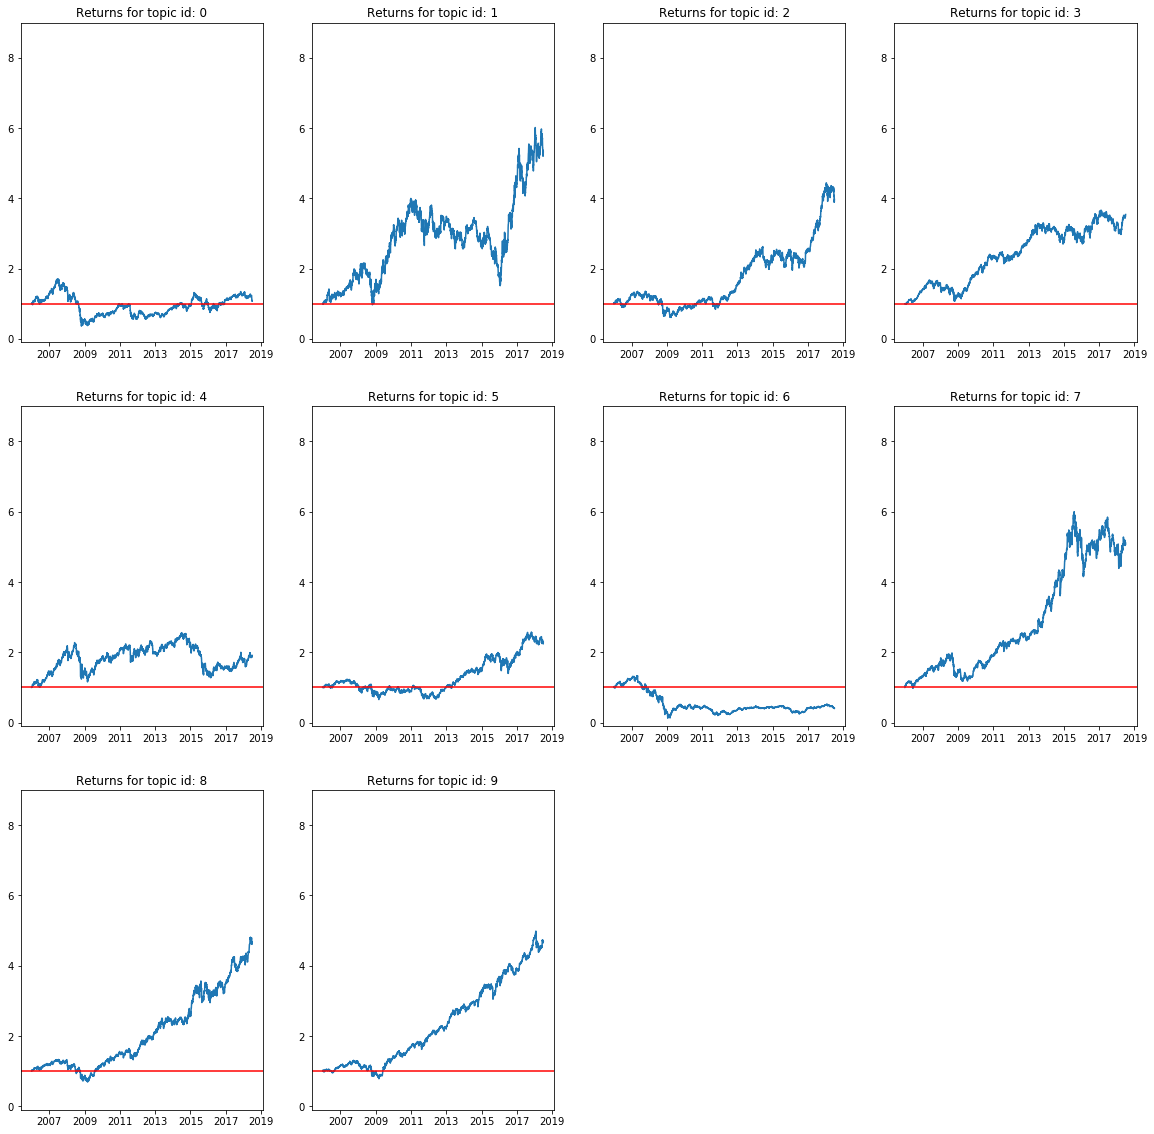

In [42]:
%matplotlib inline
columns = 2
rows = math.ceil(number_of_topics / columns)
f, ax = plt.subplots(rows, columns, figsize=(20, 20))
for row, column, topic_id in generate_subpots_indisies(rows, columns):
    if topic_id < number_of_topics:        
        topic_file = os.path.join(dir_result_portfolio, "results-%s.csv" % topic_id)
        price_df = pd.read_csv(topic_file)
        price_df['Date'] = pd.to_datetime(price_df['Date'])
        price_df.sort_values(by=['Date'], inplace=True)
        price_df.set_index('Date', inplace=True)
        ax[row, column].plot(price_df)
        ax[row, column].set_ylim(-0.1, 9)
        ax[row, column].set_title("Returns for topic id: %s" % topic_id)
        ax[row, column].axhline(y=1, color='r')
    else:
        ax[row, column].remove()

    
pp = PdfPages(os.path.join(dir_return_plots, "returns.pdf"))
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()    

In [ ]:
# TODO all topics combined ws flat investment in the all tickers